# Hello Treebeard!

Thanks for trying out Treebeard's cloud deploy and scheduling service.  


1. [Requirements](#Requirements)
2. [Outputs](#Outputs)
3. [Examples](#Examples)
    - [Call an API](#Call-an-API)
    - [Check a hosted file](#Check-a-hosted-file)

## Requirements

In [1]:
import treebeard
# This notebook does not depend on the treebeard library, but it should be present in your requirements file.
# The underlying build service sends this notebook to a cloud server which uses the papermill library to run
# the notebook. Having treebeard as a dependency ensure this functions correctly.

There must be a dependencies file alongside this notebook, either requirements.txt, a pipenv Pipfile, or a Conda environment.yml file.

In [2]:
# Setup
import os
import matplotlib.pyplot as plt 
import requests
import json
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

## Output

**Output** from your notebooks should be saved in an `output` directory.  
If so, they will be saved on the cloud build server, versioned, and made available via URL endpoints.  
They can be listed on the Treebeard admin page that you can find after running a build.

In [3]:
# create an outputs directory if it does not exist
if 'output' not in os.listdir(): os.mkdir('output')

# Examples

Here are a few simple examples of data that might be interesting to check over time.

## Call an API

What's the current price of BitCoin?

In [4]:
r = requests.get('https://api.coindesk.com/v1/bpi/currentprice.json').json()
print(f"At {r['time']['updateduk']}, the price of Bitcoin is £{r['bpi']['GBP']['rate']}")
# This data was produced from the CoinDesk Bitcoin Price Index (USD). Non-USD currency data converted using hourly conversion rate from openexchangerates.org

At Feb 11, 2020 at 11:42 GMT, the price of Bitcoin is £7,579.0896


See the last 30 days of the price of Bitcoin, thanks to CoinDesk's API

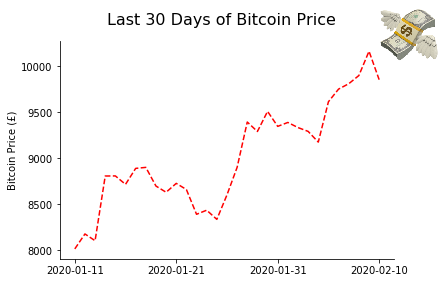

In [5]:
r = requests.get('https://api.coindesk.com/v1/bpi/historical/close.json').json()

fig, ax = plt.subplots()
ax.plot(pd.DataFrame.from_dict(r)['bpi'][:-2], color='red', linestyle='--')
ax.set_ylabel('Bitcoin Price (£)')
fig.suptitle('Last 30 Days of Bitcoin Price', size=16)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
ax.xaxis.set_major_locator(plt.MaxNLocator(4))

im = plt.imread('https://emojipedia-us.s3.dualstack.us-west-1.amazonaws.com/thumbs/320/apple/237/money-with-wings_1f4b8.png')
newax = fig.add_axes([0.8, 0.8, 0.2, 0.2], anchor='NE')
newax.imshow(im)
newax.axis('off')
plt.savefig('output/bitcoin_price.png', dpi=150, bbox_inches='tight')

## Check a hosted file

The [Mauna Loa Observatory](https://www.esrl.noaa.gov/gmd/obop/mlo/) is a USA NOAA Earth System Research Laboratory.  
It publishes measurements of **atmospheric CO2 concentration** regularly.  
The Observatory publishes its own charts [here](https://www.esrl.noaa.gov/gmd/ccgg/trends/mlo.html), but we can recreate them.

In [6]:
# Weekly CO2 data is published here, there are also other datafeeds available
url = "ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_weekly_mlo.txt"

In [7]:
# Pandas can read remote URL file contents
# Skip the first 49 rows as they are explanatory text
# Reading them is helpful though as they define the column names and missing number fills
df = pd.read_table(url, skiprows=49, header=None)

In [8]:
df[0].head()

0      1974   5  19  1974.3795    333.34  6        ...
1      1974   5  26  1974.3986    332.95  6        ...
2      1974   6   2  1974.4178    332.32  5        ...
3      1974   6   9  1974.4370    332.18  7        ...
4      1974   6  16  1974.4562    332.37  7        ...
Name: 0, dtype: object

In [9]:
# Use a regex to turn the variable whitespace between columns into commas
df[0] = df[0].str.strip().str.replace("(\s{1,})", ",")

In [10]:
# Split the column by commas and expand into columns
df = df[0].str.split(',', expand=True)

In [11]:
# Set the column headers
columns = ["yr", "mon", "day", "decimal", "ppm", "days", "1_yr_ago", "10_yr_ago", "since_1800"]
df.columns=columns

In [12]:
# Replace -999.99 with NAs
df = df.replace('-999.99', np.nan)

In [13]:
# Create datetime column
df['date'] = pd.to_datetime(dict(year=df['yr'], month=df['mon'], day=df['day']))

In [14]:
# Set types
df['ppm'] = df['ppm'].apply(pd.to_numeric)

In [15]:
df.tail()

,yr,mon,day,decimal,ppm,days,1_yr_ago,10_yr_ago,since_1800,date
2381,2020,1,5,2020.0123,413.37,7,409.94,388.21,133.26,2020-01-05
2382,2020,1,12,2020.0314,412.82,6,410.66,388.41,132.52,2020-01-12
2383,2020,1,19,2020.0505,413.65,7,412.19,388.27,133.18,2020-01-19
2384,2020,1,26,2020.0697,414.09,7,411.06,389.37,133.49,2020-01-26
2385,2020,2,2,2020.0888,414.33,7,411.11,390.67,133.62,2020-02-02


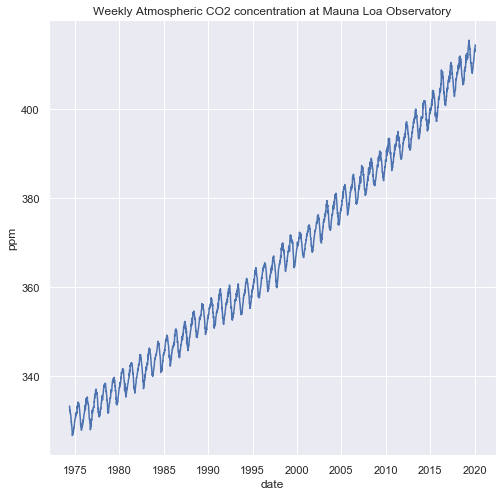

In [16]:
sns.set()
fig, ax = plt.subplots(figsize=(8,8))
sns.lineplot(x='date', y='ppm', data=df)
plt.title("Weekly Atmospheric CO2 concentration at Mauna Loa Observatory")
plt.savefig('output/co2_concentration.png', dpi=150, bbox_inches='tight')